In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle

sns.set(font_scale=1.5)

### Случайный лес.

### Задача 4.2

В этой задаче вам предлагается исследовать зависимость качества предсказаний модели случайного леса в зависимости от различных гиперпараметров на примере задаче регрессии. Будем использовать класс `RandomForestRegressor` библиотеки `sklearn`.

В качестве данных возьмём датасет `california_housing` из библиотеки `sklearn` о стоимости недвижимости в различных округах Калифорнии. Этот датасет состоит из 20640 записей и содержит следующие признаки для каждого округа: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `Population`, `AveOccup`, `Latitude`, `Longitude`. `HouseAge` и `Population` - целочисленные признаки. Остальные признаки - вещественные.

*Совет.* При отладке кода используйте небольшую часть данных. Финальные вычисления проведите на полных данных. Для оценки времени работы используйте `tqdm` в циклах.

In [2]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

Разбейте данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

Посмотрите, как изменяется качество леса в зависимости от выбранных параметров. Для этого постройте графики зависимости MSE на тестовой выборке от количества деревьев (от 1 до 100) и от максимальной глубины дерева (от 3 до 25). Когда варьируете один из параметров, в качестве другого берите значение по умолчанию.

In [4]:
def plot_dependence_test(param_grid, test_values, param_label,
                         metrics_label, title):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на валидационной выборке.
    
    Параметры.
    1) param_grid - значения исследуемого параметра,
    2) test_values - значения метрики на валидационной выборке,
    3) param_label - названия параметра,
    4) metrics_label - название метрики,
    5) title - заголовок для графика.
    '''
    
    plt.figure(figsize=(12, 6))
    plt.plot(param_grid, test_values, label='test', linewidth=3)
   
    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.legend()
    plt.title(title)
    plt.show()

Для построения зависимости от количества деревьев можно было бы построить модели для каждого количества деревьев, посчитать метрику и построить график. Однако лес -- набор этих деревьев. Построив один лес, мы можем посчитать предсказания для каждого дерева в отдельности. Затем, усредняя, получаем предсказания для произвольного количества деревьев. Такой трюк позволяет экономить время проведения эксперимента.

In [5]:
regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(X_train, y_train)

predictions_by_tree = np.array(
    [tree.predict(X_test) for tree in regressor.estimators_]
)

n_estimators_grid = np.arange(1, 101)
predictions = np.cumsum(predictions_by_tree, axis=0) \
                / n_estimators_grid[:, np.newaxis]
mse_values = [mse(p, y_test) for p in predictions]

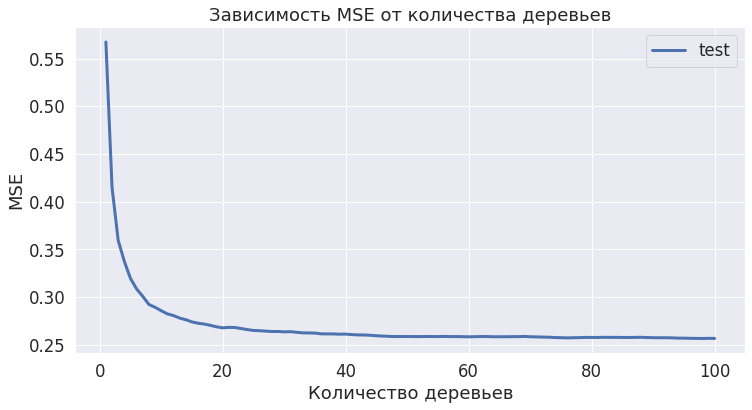

In [6]:
plot_dependence_test(n_estimators_grid, mse_values, 
                     'Количество деревьев', 'MSE', 
                     'Зависимость MSE от количества деревьев')

In [7]:
mse_values = []

for max_depth in tqdm(range(3, 25)):
    regressor = RandomForestRegressor(max_depth=max_depth, 
                                      n_estimators=50)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse_values.append(mse(predictions, y_test))

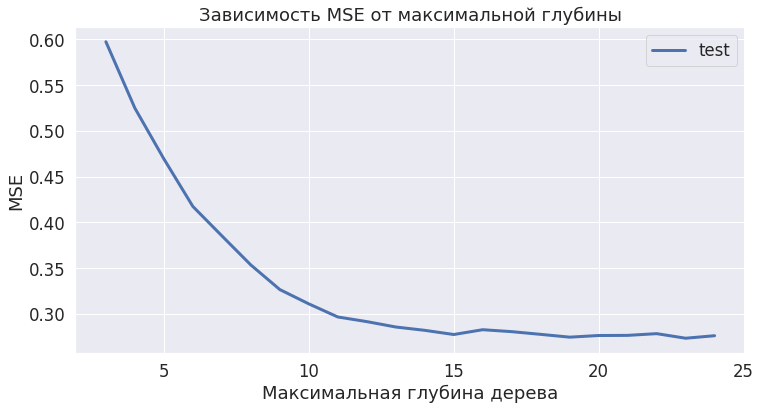

In [8]:
plot_dependence_test(np.arange(3, 25), mse_values, 
                     'Максимальная глубина дерева', 'MSE', 
                     'Зависимость MSE от максимальной глубины')

Основываясь на полученных графиках, ответьте на следующие вопросы.

1. Какие закономерности можно увидеть на построенных графиках? Почему графики получились такими?

2. Как изменяется качество предсказаний с увеличением исследуемых параметров, когда эти параметры уже достаточно большие.

3. В предыдущем задании вы на практике убедились, что решающее дерево начинает переобучаться при достаточно больших значениях максимальной глубины. Справедливо ли это утверждение для решающего леса? Поясните свой ответ, опираясь на своё знание статистики.

**Вывод.**

По первому графику можно сделать вывод, что с возрастанием числа использованных деревьев используется, MSE снижается. Но при достаточно больних значениях `n_estimators` значение MSE практически перестаёт меняться. С параметром `max_depth` ситуация аналогична. Случайный лес, в отличие от решающего дерева, гораздо менее склонен к переобучению при больших `max_depth`. Ведь использование большого количества деревьев снижает дисперсию предсказаний, а использование больших значений `max_depth` или вообще отсутствие ограничения на максимальную глубину позволяет строить модели, близкие к несмещенным, предсказания которых имеют большую дисперсию. В итоге случайный лес как комбинация большого количества глубоких деревьев имеет маленькое смещение (bias) и маленькую дисперсию.

Обучите случайный лес с параметрами по умолчанию и выведите mse на тестовой выборке. Проведите эксперимент 3 раза. Почему результаты отличаются?

In [9]:
for iteration in tqdm(range(3)):
    regressor = RandomForestRegressor(n_estimators=100)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    print('MSE = {:.4f}'.format(mse(predictions, y_test)))

MSE = 0.2728
MSE = 0.2715
MSE = 0.2707



**Ответ.** Потому что лес случайный. Он основан на `n_estimators` случайных деревьях, которые могут очень сильно отличаться друг от друга.

Было бы неплохо определиться с тем, какое количество деревьев нужно использовать и какой максимальной глубины они будут. Подберите оптимальные значения `max_depth` и `n_estimators` с помощью кросс-валидации.

In [10]:
rf_gridsearch = RandomizedSearchCV(
    estimator=RandomForestRegressor(), 
    param_distributions={
        'max_depth': np.arange(3, 30), 
        'n_estimators': np.arange(10, 200)
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=10,  # насколько часто печатать сообщения
    n_jobs=2,  # кол-во параллельных процессов
    n_iter=200  # кол-во итераций случайного выбора гиперпараметров
)

In [11]:
rf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   32.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   40.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  3.5min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  3.9min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  4.8min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  6.4min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  7.0min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  8.2min
[Parallel(

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


Выведите найденные оптимальные параметры.

In [12]:
print(rf_gridsearch.best_params_)

{'n_estimators': 189, 'max_depth': 26}


Зафиксируем эти оптимальные значения параметров и в дальнейшем будем их использовать.

In [13]:
max_depth = rf_gridsearch.best_params_['max_depth']
n_estimators = rf_gridsearch.best_params_['n_estimators']

Оценим качество предсказаний обученного решающего леса.

In [14]:
predictions = rf_gridsearch.best_estimator_.predict(X_test)
print('{:.4f}'.format(mse(predictions, y_test)))

0.2700


Исследуйте зависимость метрики `mse` от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

Не забывайте делать пояснения и выводы!

In [15]:
mse_train_values = []
mse_test_values = []

for n_features in tqdm(range(1, 9)):
    rf_regressor = RandomForestRegressor(max_depth=max_depth, 
                                         n_estimators=n_estimators, 
                                         max_features=n_features)
    rf_regressor.fit(X_train, y_train)
    
    current_train_mse = mse(rf_regressor.predict(X_train), y_train)
    current_test_mse = mse(rf_regressor.predict(X_test), y_test)
    print('n_features: {}, train_mse: {:.4f}, test_mse: {:.4f}'.format(
        n_features, current_train_mse, current_test_mse
    ))
    
    mse_train_values.append(current_train_mse)
    mse_test_values.append(current_test_mse)

n_features: 1, train_mse: 0.0387, test_mse: 0.2898
n_features: 2, train_mse: 0.0330, test_mse: 0.2493
n_features: 3, train_mse: 0.0328, test_mse: 0.2500
n_features: 4, train_mse: 0.0335, test_mse: 0.2547
n_features: 5, train_mse: 0.0339, test_mse: 0.2610
n_features: 6, train_mse: 0.0345, test_mse: 0.2615
n_features: 7, train_mse: 0.0349, test_mse: 0.2673
n_features: 8, train_mse: 0.0352, test_mse: 0.2712



Постройте график зависимости метрики mse на `test` и `train` в зависимости от числа признаков, использующихся при разбиении в каждой вершине.

In [16]:
def plot_dependence(param_grid, train_values, test_values, 
                    param_label='', metrics_label='', title='',
                    train_label='train', test_label='test', 
                    create_figure=True):
    '''
    Функция для построения графиков зависимости целевой метрики 
    от некоторого параметра модели на обучающей и на валидационной 
    выборке.
    
    Параметры.
    1) param_grid - значения исследуемого параметра,
    2) train_values - значения метрики на обучающей выборке,
    3) test_values - значения метрики на валидационной выборке,
    4) param_label - названия параметра,
    5) metrics_label - название метрики,
    6) title - заголовок для графика,
    7) create_figure - флаг, устанавливающий нужно ли создавать 
    новую фигуру для графика.
    '''
    
    if create_figure:
        plt.figure(figsize=(12, 6))
    plt.plot(param_grid, train_values, label=train_label, linewidth=3)
    plt.plot(param_grid, test_values, label=test_label, linewidth=3)
       
    plt.legend()
    if create_figure:
        plt.xlabel(param_label)
        plt.ylabel(metrics_label)
        plt.title(title, fontsize=20)

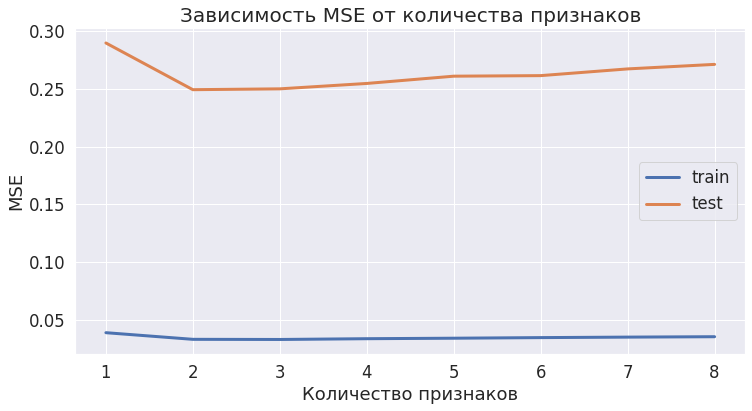

In [17]:
plot_dependence(range(1, 9), mse_train_values, mse_test_values, 
                'Количество признаков', 'MSE', 
                'Зависимость MSE от количества признаков')

Почему график получился таким? Как зависит разнообразие деревьев от величины `n_features`?

**Вывод.**

Как можно заметить по графику, оптимальное число признаков для тестовой выборки равно 3, а для обучающей выборки ошибка практически не меняется с увеличением количества признаков. Значит, действительно не всегда стоит выбирать при каждом разбиении вершины из всех признаков, поскольку это может привести к переобучению.
При этом, при увеличении значения `n_features` деревья в случайном лесу становятся всё более похожими друг на друга и их попарная корреляция увеличивается. При этом, если взять значение `n_features` равным количеству признаков в датасете, то в каждой вершине деревья будут оптимизировать значения одинакового функционала, выбирая признак из одинакового множества признаков, и останется единственный фактор случайности - бутсрепированная выборка, которая может меняться у разных деревьев. 

Проведите эксперимент, в котором выясните, как изменится качество регрессии, если набор признаков, по которым происходит разбиение в каждой вершине определяется не заново в каждой вершине, а задан заранее. Поскольку результаты эксперимента могут сильно зависеть от того, какой набор признаков задан изначально, проведите несколько экспериментов для каждого значения `n_features`. 

Для реализации данного эксперимента используйте класс беггинг-модели `sklearn.ensemble.BaggingRegressor`, у которого используйте следующие поля:
* `base_estimator` -- базовая модель, используйте `sklearn.tree.DecisionTreeRegressor`
* `max_features` -- количество признаков для каждой базовой модели
* `n_estimators` -- количество базовых моделей.

Постройте графики `mse` на обучающей и на валидационной выборке.

In [20]:
stupid_mse_train_values = []
stupid_mse_test_values = []

for n_features in tqdm(range(1, 9)):
    rf_regressor = BaggingRegressor(
        base_estimator=DecisionTreeRegressor(
            max_depth=max_depth
        ), 
        max_features=n_features,
        n_estimators=100
    )
    
    rf_regressor.fit(X_train, y_train)
    current_train_mse = mse(rf_regressor.predict(X_train), y_train)
    current_test_mse = mse(rf_regressor.predict(X_test), y_test)
    print('n_features: {}, train_mse: {:.4f}, test_mse: {:.4f}'.format(
          n_features, current_train_mse, current_test_mse))
    
    stupid_mse_train_values.append(current_train_mse)
    stupid_mse_test_values.append(current_test_mse)

n_features: 1, train_mse: 0.5825, test_mse: 0.9509
n_features: 2, train_mse: 0.1199, test_mse: 0.6213
n_features: 3, train_mse: 0.0657, test_mse: 0.4400
n_features: 4, train_mse: 0.0431, test_mse: 0.3013
n_features: 5, train_mse: 0.0360, test_mse: 0.2663
n_features: 6, train_mse: 0.0332, test_mse: 0.2452
n_features: 7, train_mse: 0.0344, test_mse: 0.2579
n_features: 8, train_mse: 0.0362, test_mse: 0.2715



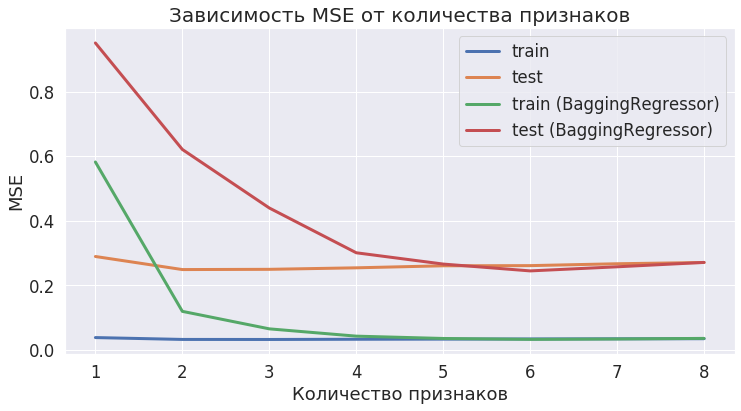

In [21]:
plot_dependence(range(1, 9), mse_train_values, mse_test_values, 
                'Количество признаков', 'MSE', 
                'Зависимость MSE от количества признаков')
plot_dependence(range(1, 9), stupid_mse_train_values, 
                stupid_mse_test_values,
                train_label='train (BaggingRegressor)', 
                test_label='test (BaggingRegressor)',
                create_figure=False)

Сравните результаты обычного случайного леса с только что построенным лесом.

Сделайте выводы. Объясните, чем плох такой подход пострения случайного леса. Какое преимущество мы получаем, когда выбираем случайное подмножество признаков в каждой вершине в обычном случайном лесу?

**Вывод.**

Во всех экспериментах при фиксации набора признаков значение MSE стало больше, чем
без фиксации признаков. Из этого можно сделать вывод, что фиксировать признаки
заранее - плохая идея. Действительно, если мы строим дерево таким образом, то мы, по
сути, просто отказываемся от некоторых признаков и надеемся, что без них регрессия
будет давать хороший результат. Из-за этого множество различных деревьев сужается. Значит, увеличится дисперсия предсказаний и, как следствие, MSE. 

### Задача 4.3

На лекции получена формула bias-variance разложения для беггинга. Проведите эксперимент, в котором выясните, насколько уменьшается разброс (variance-компонента) беггинг-модели на 100 базовых моделях по отношению к одной базовой модели. Используйте данные из предыдущей задачи. Рассмотрите беггинг на следующих базовых моделях:
* решающие деревья, можно использовать вариант случайного леса.
* ридж-регрессия.

Для решения задачи потребуется оценить корреляции предсказаний на тестовой выборке базовых моделей, входящих в состав беггинг-модели. Их можно получить с помощью поля `estimators_` у обученной беггинг-модели.

Насколько уменьшается разброс в каждом случае? Для каждого случая постройте также матрицу корреляций предсказаний базовых моделей и гистограмму по ним. Какую оценку коэффициента корреляции вы используете и почему?

Обучим случайный лес и бэггинг над `Ridge`-регрессией.

In [20]:
ridge_bagging = BaggingRegressor(base_estimator=Ridge(), n_estimators=100).fit(X_train, y_train)
rf_regressor = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)

В качестве оценки коэффициента корреляции будем использовать коэффициенты Спирмeна и Пирсона. Коэффициент Пирсона оценивает степень линейной зависимости между выборками. Поскольку в variance-компоненте содержится теоретическая ковариация, тоже характеризующая степень линейной зависимости, использование коэффициента Пирсона логично в этой задаче. А коэффициент Спирмeна будем использовать, потому что он устойчив к выбросам.

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


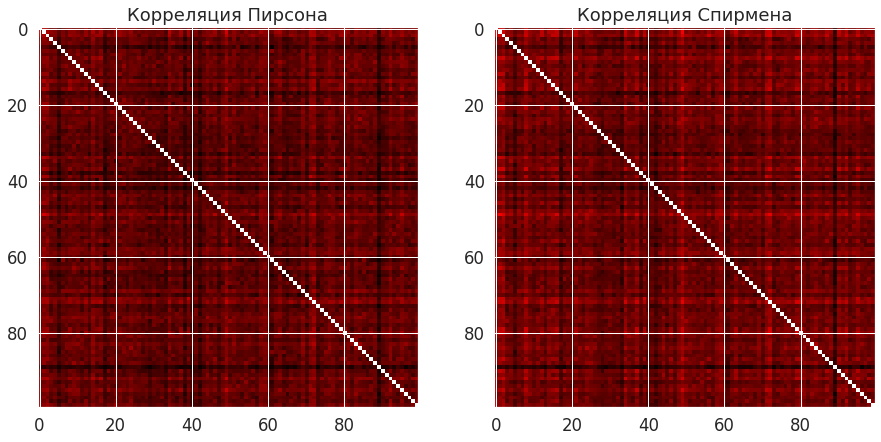

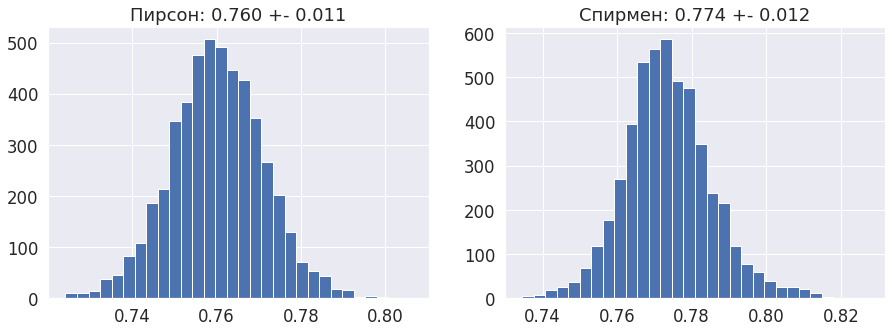

BaggingRegressor(base_estimator=Ridge(alpha=1.0, copy_X=True,
                                      fit_intercept=True, max_iter=None,
                                      normalize=False, random_state=None,
                                      solver='auto', tol=0.001),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=100, n_jobs=None,
                 oob_score=False, random_state=None, verbose=0,
                 warm_start=False)


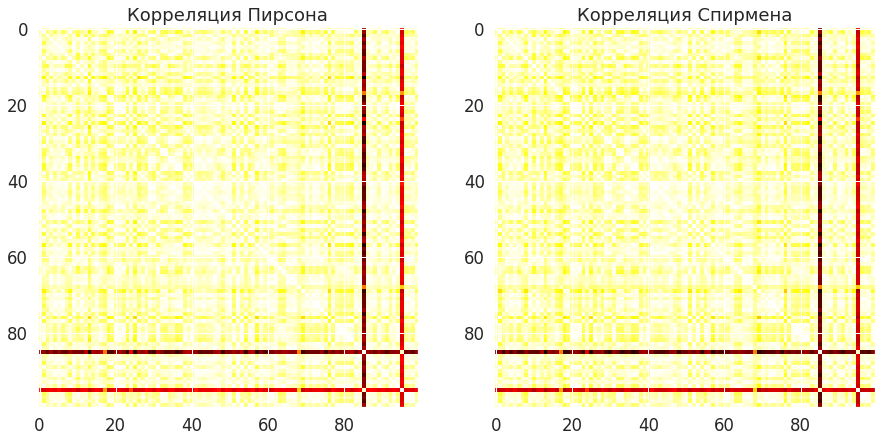

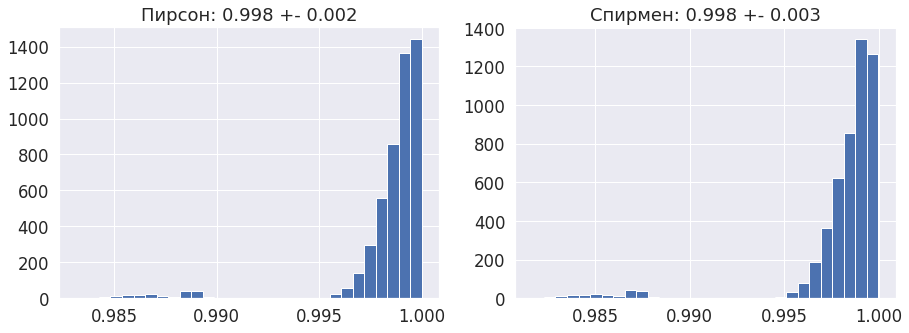

In [21]:
for model in [rf_regressor, ridge_bagging]:
    print(model)
    
    predictions = [
        estimator.predict(X_test) for estimator in model.estimators_
    ]
    estimators_count = len(model.estimators_)
    
    pearson_matrix = np.zeros((estimators_count, estimators_count))
    spearman_matrix = np.zeros((estimators_count, estimators_count))
    for i in range(estimators_count):
        for j in range(i, estimators_count):
            pearson_matrix[i, j] = sps.pearsonr(predictions[i], 
                                                predictions[j])[0]
            spearman_matrix[i, j] = sps.spearmanr(predictions[i], 
                                                  predictions[j])[0]
            pearson_matrix[j, i] = pearson_matrix[i, j]
            spearman_matrix[j, i] = spearman_matrix[i, j]
    
    # визуализируем полученные матрицы ковариаций
    plt.figure(figsize=(15, 7))
    plt.subplot(121)
    plt.imshow(pearson_matrix, interpolation='none', cmap='hot')
    plt.title('Корреляция Пирсона')
    plt.subplot(122)
    plt.imshow(spearman_matrix, interpolation='none', cmap='hot')
    plt.title('Корреляция Спирмена')
    plt.show()
    
    plt.figure(figsize=(15, 5))
    
    # построим гистограммы ковариаций
    plt.subplot(121)
    ravel_corr = pearson_matrix[np.tril_indices(100, k=-1)]
    plt.hist(ravel_corr, bins=30)
    plt.title('Пирсон: {:.3f} +- {:.3f}'.format(ravel_corr.mean(), 
                                                ravel_corr.std()))
    
    plt.subplot(122)
    ravel_corr = spearman_matrix[np.tril_indices(100, k=-1)]
    plt.hist(ravel_corr, bins=30)
    plt.title('Спирмен: {:.3f} +- {:.3f}'.format(ravel_corr.mean(), 
                                                 ravel_corr.std()))
    
    plt.show()

Посчитаем разброс бэггинга над `Ridge`-регрессией.

In [26]:
ridge_var = 1/100 + 99/100 * 0.998
print(ridge_var)

0.99802


Посчитаем разброс случайного леса.

In [27]:
rf_var = 1/100 + 99/100 * 0.76
print(rf_var)

0.7624


Оценим, во сколько раз бэггинг уменьшил разброс предсказаний базовых моделей.

Для леса:

In [28]:
1 / rf_var

1.311647429171039

Для `Ridge`-регрессии:

In [29]:
1 / ridge_var

1.001983928177792

**Вывод.**

Как мы видим, в обоих случаях разброc предсказаний увеличился, но в достаточно малое число раз. Это произошло из-за того, что базовые модели, как деревья, так и линейные регрессии получились сильно коррелированными.

В случайном лесе базовые модели оказались менее коррелированными, чем в бэггинге над `Ridge`-регрессией. Это связано с тем, что в лесе деревья могут достаточно разнообразными в отличии от линейной регрессией.